In [118]:
import zipfile, requests, io
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from  matplotlib import cm
import seaborn as sns
import math
from matplotlib.patches import Patch
import statsmodels.api as sm
import sklearn as sk
import statsmodels.formula.api as smf
from collections import Counter

In [27]:
# import related Toronto open data

root = "./data/"
'''
links = ["http://opendata.toronto.ca/gcc/neighbourhoods_planning_areas_wgs84.zip",
         "http://opendata.toronto.ca/gcc/business_improvement_areas_wgs84.zip",
         "http://opendata.toronto.ca/gcc/centreline_wgs84.zip"]


for link in links:
    r = requests.get(link)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(root)
'''

neighboorhoods = gpd.read_file(root + "NEIGHBORHOODS_WGS84.shp")
centerlines = gpd.read_file(root + "centreline_wgs84.shp")
bia = gpd.read_file(root + "BUSINESS_IMPROVEMENT_AREA_WGS84.shp")

# import Geotab data
idling_area = pd.read_json(root + "idlingArea.json", lines=True)
parking = pd.read_json(root + "searchingForParking.json", lines=True)

# clean idling data
def convert_hour_distribution(x):
    to_dict = eval(str(x).replace('null', '-1'))
    to_list = []
    for key, val in to_dict.items():
        to_list.append(val if val != -1 else np.nan)
    return np.array(to_list)

idling_area.HourlyDistribution = idling_area.HourlyDistribution.apply(convert_hour_distribution)
idling_area.IdlingByHour = idling_area.IdlingByHour.apply(convert_hour_distribution)
idling_area['geometry'] = idling_area.apply(lambda x: [(x.Longitude_NE, x.Latitude_NE), 
                                                  (x.Longitude_NE, x.Latitude_SW),
                                                  (x.Longitude_SW, x.Latitude_SW),
                                                  (x.Longitude_SW, x.Latitude_NE)], axis=1).apply(Polygon)
idling_area = gpd.GeoDataFrame(idling_area)

## I.  Introduction

> If all drivers avoided unnecessary idling for three minutes a day, we would save over $\$630$ million per year (assuming a fuel cost of $\$1$/litre). What's more‚ collectively‚ we would prevent 1.4 million tonnes of carbon dioxide (CO2) from entering the atmosphere daily and contributing to climate change.  
— quoted from Natural Resources Canada. _Why do Canadians idle?_
 
Despite the effort from the government, idling is still a problem for cities. Among different kinds of vehicles, commercial vehicles are one of the big source of idling-related problems. Commercial vehicles spend much longer time on the road and the heavy duty trucks produce more emission than the small common cars. Therefore, with the Geotab data on commercial vehicles, we seek ways to reduce idling of commercial vehicles in Toronto. We will look at the areas, time, and type of vehicles to find reasons behind idling and make suggestions on the improvements. 

## II. Data Overview

This data report primarily uses data from Geotabs's _Areas of Idling_ and _Searching For Parking_ data sets. The Geotab data set are derived at aggregate from the commercial vehicles in Geotab's data environment, which 70% are trucks, 10% are passenger cars, 16% are multi-purpose vehicles, and 4% are buses (<a href="#r_ourdata" id="p_ourdata">1</a>). 

In addition to the Geotab's datasets, this report will use map data from City of Toronto Open Data, including the following:

 - _Toronto Centreline_(<a href="#r_tcl" id="p_tcl">2</a>): Including linear features representing streets, walkways, rivers, railways, highways and administrative boundaries within the City of Toronto.
 - _Business Improvement Area_(<a href="#r_bia" id="p_bia">3</a>): Including the boundaries of business improvement areas in city of Toronto.
 - _Neighborhood_(<a href="#r_neighbor" id="p_neighbor">4</a>): Including the boundaries of all city of Toronto neighborhoods .


## III. Identify idling problems and idling areas

For the purpose of reducing idling time, cumulative idle time seems to be the most conclusive measurement. However, the total idling time is highly correlated with the traffic volume. Simply report the idling problem based on cumulative idle time is less meaningful. Therefore, I identify the following three idling problems.

| problem of the area | data to look at | reasons for this measurement| 
| --- | --- | --- | 
|long cumulative idling time | CumulativeDailyIdleTime | more intuitive and directive measurement of idling time |
| high proportion of idling (idling instances / all traffic) | IdlingByHour | identify areas where cars are more likely to idle | 
| long idling time of idling instances | AverageIdleTime, MedianIdleTime | understand why cars idle longer in these areas | 


Notice that the data set only includes the hourly proportion of idling vehicles. To obtain a significant representation of the daily proportion of idling, I propose to take the mean proportion of the daytime (8:00-20:00). I choose to exclude the nighttime because there is much less traffic at night.

Then, I look at the distribution of the three factors through histograms and boxplot. 

In [28]:
# calculate the mean proportion
idling_area['IdleMean'] = idling_area['IdlingByHour'].apply(lambda x: x[8:20].mean())

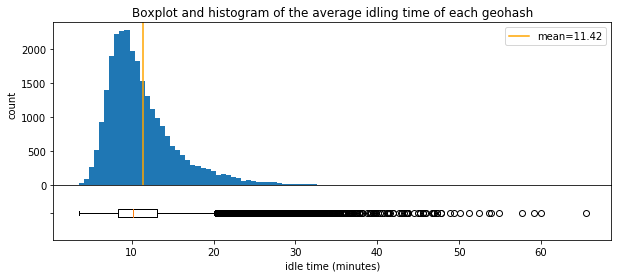

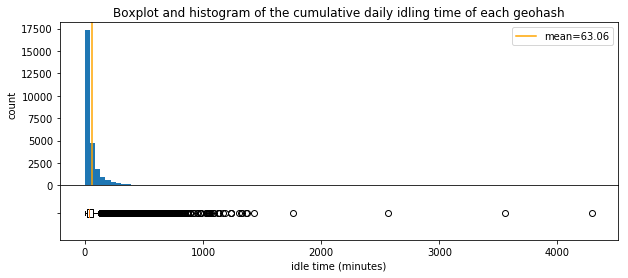

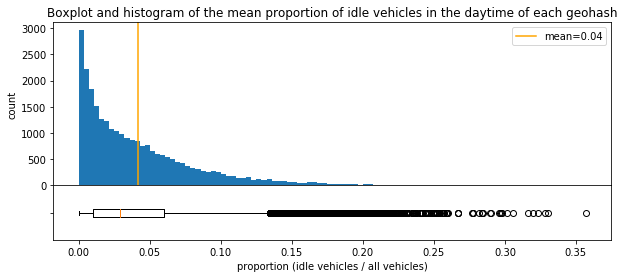

In [236]:
variables = ['AverageIdleTime', 'CumulativeDailyIdleTime', 'IdleMean']
var_texts = ['average idling time', 'cumulative daily idling time', 'mean proportion of idle vehicles in the daytime']
label_texts = ['idle time (minutes)', 'idle time (minutes)', 'proportion (idle vehicles / all vehicles)']
upper_whiskers = []

for i in range(3):
    fig, axs = plt.subplots(2,figsize=(10,4), sharex=True, gridspec_kw={"height_ratios": (.75, .25)})
    plt.subplots_adjust(wspace=0, hspace=0)
    box = axs[1].boxplot(idling_area[variables[i]].dropna(), vert=False)
    axs[1].set_yticklabels("")
    axs[0].hist(idling_area[variables[i]].dropna(), bins=100)
    axs[0].axvline(idling_area[variables[i]].dropna().mean(), color="orange")
    axs[0].set_title("Boxplot and histogram of the "+var_texts[i]+" of each geohash")
    axs[1].set_xlabel(label_texts[i])
    axs[0].set_ylabel("count")
    axs[0].legend(["mean="+str(round(idling_area[variables[i]].dropna().mean(), 2))])
    upper_whiskers.append(box['whiskers'][1].get_xdata()[1]);

Although the distributions are quite different, the distributions are all heavily right-skewed. To identify the areas with idling problems, I propose to look at the areas from each measurement where the measurement is greater than the upper whisker (greater than 1.5IQR of the upper quartile). I choose this classification because such areas have measurements that are abnormally greater than the rest areas. 

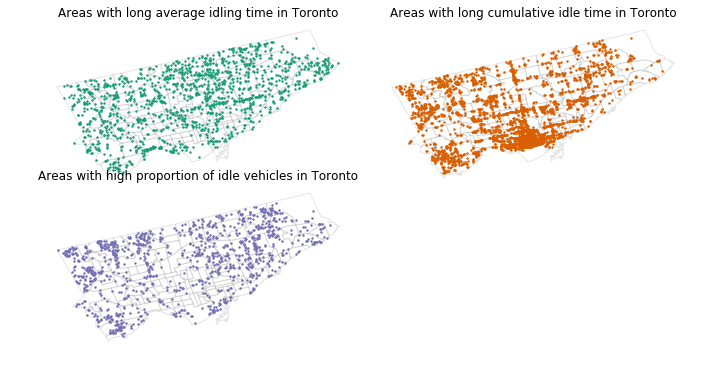

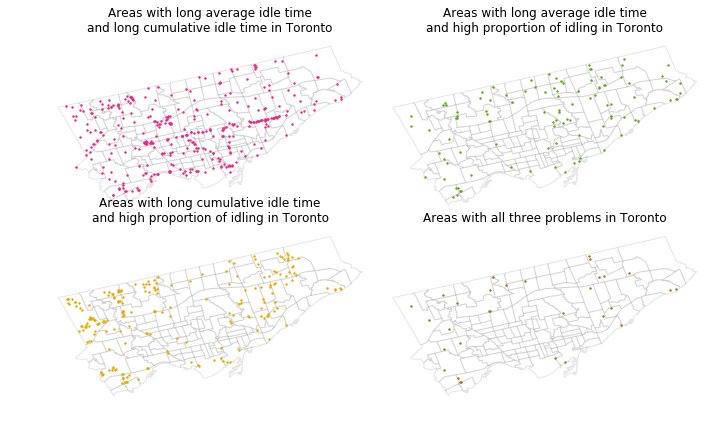

In [240]:
problem_areas = [idling_area.loc[idling_area[variables[0]] > upper_whiskers[0]],
                 idling_area.loc[idling_area[variables[1]] > upper_whiskers[1]],
                 idling_area.loc[idling_area[variables[2]] > upper_whiskers[2]]]
problem_areas += [idling_area.loc[problem_areas[0].index.intersection(problem_areas[1].index)], 
                  idling_area.loc[problem_areas[0].index.intersection(problem_areas[2].index)], 
                  idling_area.loc[problem_areas[1].index.intersection(problem_areas[2].index)], 
                  idling_area.loc[problem_areas[0].index.intersection(problem_areas[1].index).intersection(problem_areas[2].index)]]
color = "#1b9e77,#d95f02,#7570b3,#e7298a,#66a61e,#e6ab02,#a6761d".split(",")
problem_labels = ['long average idling time', 
                  'long cumulative idle time', 
                  'high proportion of idle vehicles', 
                  'long average idle time\nand long cumulative idle time', 
                  'long average idle time\nand high proportion of idling', 
                  'long cumulative idle time\nand high proportion of idling', 
                  'all three problems']

fig, axs = plt.subplots(2,2, figsize = (12, 6))
plt.subplots_adjust(wspace=0, hspace=0)
for i in range(3):
    axs[i//2][i%2].set_axis_off()
    neighboorhoods.plot(alpha=0.2, color="white", edgecolor="grey", linewidth=1, ax=axs[i//2][i%2])
    problem_areas[i]['geometry'].centroid.plot(color=color[i], ax=axs[i//2][i%2], markersize=2)
    axs[i//2][i%2].set_title("Areas with "+problem_labels[i]+" in Toronto")
axs[1][1].set_axis_off() 
fig, axs = plt.subplots(2, 2, figsize = (12, 7), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0)
for i in range(4):
    axs[i//2][i%2].set_axis_off()
    neighboorhoods.plot(alpha=0.2, color="white", edgecolor="grey", linewidth=1, ax=axs[i//2][i%2])
    problem_areas[i+3]['geometry'].centroid.plot(color=color[i+3], ax=axs[i//2][i%2], markersize=2)
    axs[i//2][i%2].set_title("Areas with "+problem_labels[i+3]+" in Toronto")

As expected, most areas with high cumulative idle time are located in downtown and along major arterials, where the traffic volume are significantly greater than the other areas. However, the areas with high average idling time and areas with high idling proportion are spread through the city and has no obvious pattern. Also, there are no obvious patterns when I look at the areas with overlapped problems. 

Therefore, we need further investigation with better categorizations. 

## IV. What is the relationship between idling problems and its locations. 

### 4.1. Is there an association between the type of the road and the idling problems?


Since different road types handles different scopes of traffic within the city, they should have quite different idling issues. Therefore, I'm interested in the relationship between different types of road and their idling problems. 

For the road types, I obtained road data from _Toronto centerlines_(TCL). TCL categorizes traffic paths and other linear features in Toronto into 26 groups. I'm interested in expressway, major arterial, minor arterial, and local roads. Then, I perform a spatial join between geohashes and interested roads and categorize geohashes by the most important type of road it intersects. The importance is defined from the most important to the least important as expressway, major arterial, minor arterial, local roads. The categorization is presented in the map below. 

In [31]:
chosen_type = ['Expressway', 'Major Arterial', 'Minor Arterial', 'Local']
idling_roads = gpd.GeoDataFrame()
idling_area.crs = centerlines.crs
for i in range(4):
    joined = gpd.sjoin(idling_area, centerlines.loc[centerlines.FCODE_DESC == chosen_type[i]])
    joined = joined.drop(joined.index.intersection(idling_roads.index))
    idling_roads = idling_roads.append(joined)
idling_roads = idling_roads.drop_duplicates(["Geohash"])

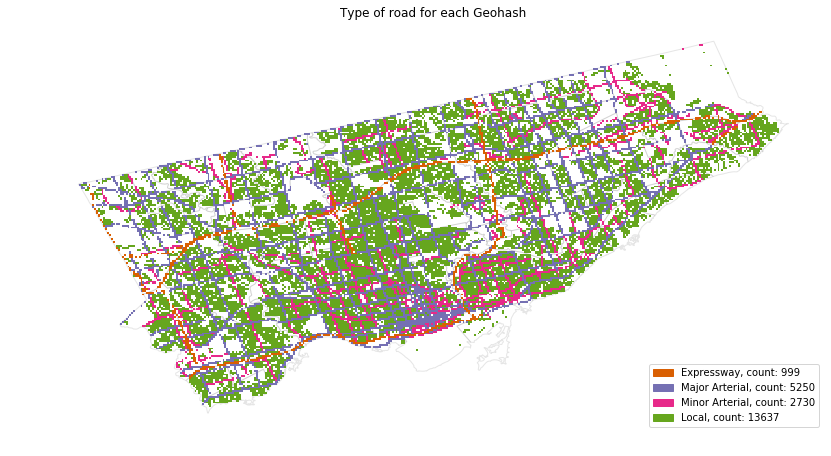

In [32]:
ax = neighboorhoods.plot(figsize=(14,10), edgecolor="grey", alpha=0.2, color="white")
handles = []
for i in range(4):
    chosen = idling_roads.loc[idling_roads.FCODE_DESC == chosen_type[i]]
    chosen.plot(color=color[i+1], ax=ax)
    handles.append(Patch(color=color[i+1], label=chosen_type[i] + ", count: "+str(len(chosen))))
ax.set_axis_off()
ax.set_title("Type of road for each Geohash")
ax.legend(handles=handles, loc=4);

First, I look at the association between road types and proportion of idling. 

I use side by side boxplots to investigate the distribution of the proportion of idling of each road type. 

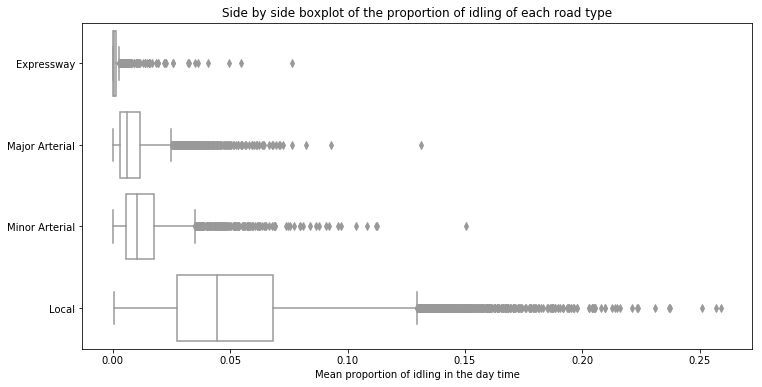

In [33]:
fig = plt.figure(figsize=(12,6))
ax = sns.boxplot(x="IdleMean", y="FCODE_DESC", data=idling_roads.loc[idling_roads.IdleMean != 0], color="white")
ax.set_title("Side by side boxplot of the proportion of idling of each road type");
ax.set_ylabel("")
ax.set_xlabel("Mean proportion of idling in the day time");

The difference is very obviously. The observations follow our common expectation, major roads have much smaller proportion of idling comparing to the local roads. Also, the variations of proportion for expressway is extremely small since idling is often unusual and dangerous on highways. 


Then, I want to investigate the relationship between average idle time and the road types. I used side by side boxplot to examine the distribution of the average idle time for each road type. 

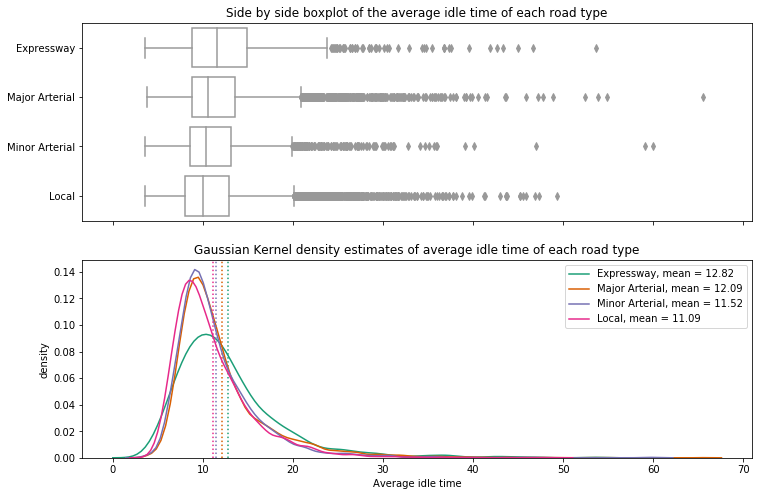

In [34]:
fig, axs = plt.subplots(2, figsize=(12,8), sharex=True)
sns.boxplot(x="AverageIdleTime", y="FCODE_DESC", data=idling_roads, ax=axs[0], color="white")
axs[0].set_title("Side by side boxplot of the average idle time of each road type");
axs[0].set_ylabel("")
axs[0].set_xlabel("")
for i in range(4):
    chosen_data = idling_roads.loc[idling_roads.FCODE_DESC == chosen_type[i]].AverageIdleTime
    sns.distplot(chosen_data, hist=False, ax=axs[1], color=color[i],
                 label=chosen_type[i] + ", mean = " + str(round(chosen_data.mean(),2)))
    axs[1].axvline(chosen_data.mean(), color=color[i], linestyle=":")
axs[1].set_xlabel("Average idle time")
axs[1].set_ylabel("density")
axs[1].set_title("Gaussian Kernel density estimates of average idle time of each road type");

There are only minor differences in mean and quartiles among different major arterial, minor arterial, and local roads. Also, the three road types have almost identical distributions. On the other hand, expressway has a different distribution, its mean and quartiles are also greater then the rest road types. 

Therefore, I group the data into expressway and non-expressway and performed two-sample permutation tests. The null hypothesis is that there is no difference in mean and median in the two groups. 

In [35]:
from scipy.special import comb
from itertools import combinations

def permutation_test(A, B, N=0, stats="mean"):
    A, B = np.array(A), np.array(B)
    num = comb(len(A) + len(B), len(A), exact=True) if N == 0 else N
    func = getattr(np, stats)
    sample_stats = func(A) - func(B)
    
    rand_dist = np.zeros(num)
    pooled = np.array(np.concatenate((A, B)))

    for i in range(N):
        np.random.shuffle(pooled)
        pooled = list(pooled)
        x1 = pooled[:len(A)]
        x2 = pooled[len(A):]
        rand_dist[i] = func(x1) - func(x2)
    
    return {"p": sum(abs(rand_dist) > abs(sample_stats)) / len(rand_dist),
            "distribution": rand_dist, 
            "ob": sample_stats}

express = idling_roads.loc[idling_roads.FCODE_DESC == "Expressway"].AverageIdleTime
non_express = idling_roads.loc[idling_roads.FCODE_DESC != "Expressway"].AverageIdleTime

N = 2500
result_mean = permutation_test(express, non_express, N, stats="mean")
result_median = permutation_test(express, non_express, N, stats="median")

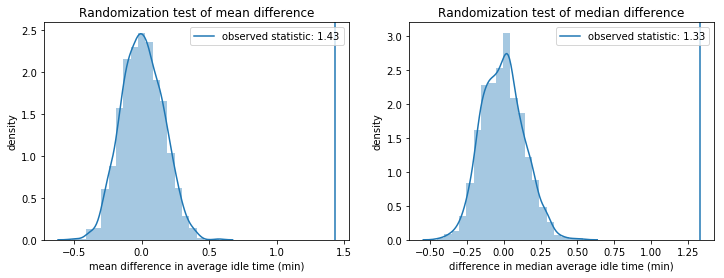

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
sns.distplot(result_mean['distribution'], bins = 20, ax=axs[0])
axs[0].axvline(result_mean['ob'],  label="observed statistic: "+str(round(result_mean['ob'], 2)))
axs[0].legend()
axs[0].set_title("Randomization test of mean difference")
axs[0].set_xlabel("mean difference in average idle time (min)")

axs[0].set_ylabel("density")
sns.distplot(result_median['distribution'], bins = 20, ax=axs[1])
axs[1].axvline(result_median['ob'], label="observed statistic: "+str(round(result_median['ob'], 2)))
axs[1].legend()
axs[1].set_title("Randomization test of median difference")
axs[1].set_xlabel("difference in median average idle time (min)")
axs[1].set_ylabel("density");

For both tests, the p-value is 0.0. We reject our null hypothesis. There is strong evidence that average idle time on the expressways is greater than the time on other road types. 

### 4.2. Does idling happens more frequently in business areas or non-business areas?

Loading trucks, drop-in delivery, waiting for passengers are some common reasons for commercial vehicles to idle, and often these activities happen in industrial areas and business areas. Therefore, I'm interested in whether the idling problems is more common in  business areas than the other areas. 

To define business areas, I use business improvement areas from Toronto Open Data. These areas are often more concentrated with businesses, factories, and warehouses. Then, I join the geohashes with BIA boundaries, the geocoding is shown below.

In [37]:
idling_bia = gpd.GeoDataFrame(idling_area)
bia_index = gpd.sjoin(idling_area, bia, op="intersects").index
idling_bia['bia'] = np.array([row in bia_index for row in idling_bia.index])

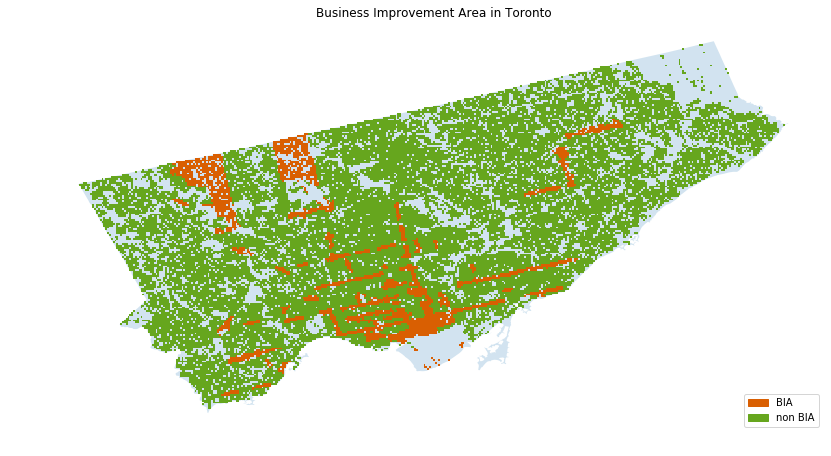

In [38]:
ax = neighboorhoods.plot(alpha=0.2, figsize=(14,8))
idling_bia.loc[idling_bia.bia].plot(ax=ax, color=color[1])
idling_bia.loc[idling_bia.bia == False].plot(ax=ax, color=color[4])
ax.legend(handles = [Patch(color=color[1], label='BIA'), 
                     Patch(color=color[4], label='non BIA')], loc=4)
ax.set_title("Business Improvement Area in Toronto")
ax.set_axis_off()

First, looking at the issue of high proportion of idling. The areas with mean proportion of idling greater than the upper-whisker is considered to have idling problem. Then, I use the contingency table and perform a chi-square contingency table test. The null hypothesis is that having high idling proportion problem is independent of whether belonging to some BIA. The alternative hypothesis is that  having high idling proportion problem is dependent of whether belonging to some BIA. 

In [39]:
tab = pd.crosstab(idling_bia.bia, (idling_bia.IdleMean > upper_whiskers[2]))
table = sm.stats.Table(tab)
# print("p-value =", table.test_nominal_association().pvalue)
# print(table.fittedvalues)

| - | not BIA | is BIA | total |
|---|---|---|---|
|Don't have problem | 23065 | 942 | 24007 |
|Have problem | 2754 | 148 | 2902 | 
| total | 25819 | 1090 | 26909 |

\begin{center}
\textit{Number of geoshes for whether in BIA and whether having problem}
\end{center}

| - | not BIA | is BIA | total |
|---|---|---|---|
|Don't have problem | 23035 | 972 | 24007 |
|Have problem | 2784 | 118 | 2902 | 
| total | 25819 | 1090 | 26909 |

\begin{center}
\textit{Expected values of the contingency table}
\end{center}

The p-value is $2.40\times 10^{-2}$, which is very small. Therefore, we can reject the null hypothesis. There is some evidence that having high idling proportion problem is dependent of whether belonging to some BIA.

Then, we look at the overall distribution of the proportion of idling in BIA and non-BIA geohashes. 

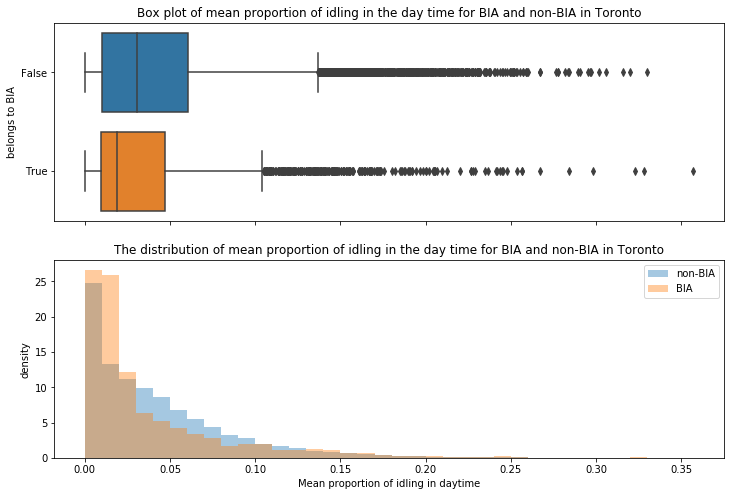

In [40]:
fig, axs = plt.subplots(2, figsize=(12,8), sharex=True)
sns.boxplot(x=idling_bia["IdleMean"], y=idling_bia["bia"].astype(str), ax=axs[0])
sns.distplot(idling_bia.loc[idling_bia.bia == False].IdleMean.dropna(), ax=axs[1], 
             bins=np.arange(0, 0.35, 0.01), kde=False, norm_hist=True, label="non-BIA")
sns.distplot(idling_bia.loc[idling_bia.bia].IdleMean.dropna(), 
             bins=np.arange(0, 0.35, 0.01), kde=False, norm_hist=True, label="BIA", ax=axs[1])

axs[0].set_title("Box plot of mean proportion of idling in the day time for BIA and non-BIA in Toronto")
axs[0].set_ylabel("belongs to BIA")
axs[0].set_xlabel("")
axs[1].set_title("The distribution of mean proportion of idling in the day time for BIA and non-BIA in Toronto")
axs[1].set_ylabel("density")
axs[1].set_xlabel("Mean proportion of idling in daytime")
axs[1].legend();

Obviously, the distribution of the idling proportion for BIA is more concentrated to the left than the idling proportion for non-BIA. Overall, BIA geohashes has smaller proportion of idling than non-BIA geohashes. 

An interesting observation is that we observe significantly more problem areas in BIA than we expected (148 vs. 117.55), which the BIA geohashes are more likely to have high idling proportion problems. However, the overall distribution shows that BIA has overall smaller proportion of idling. One possible explanation is that the commercial areas in BIA have better regulations while the industrial areas in BIA have poor regulations. Therefore, the type of area need a more detailed categorization, rather than BIA vs. non-BIA. 

## V. What is the relationship between area of idling and the time of a day?


###  5.1. Does more idling happen in rush hours?

Because Geotab determines idling by checking whether the car moves, the traffic jam might be the reason, as lots of vehicles are cogged on the road. They may explain the areas with high cumulative idling time and low average idling time. We checked the traffic volume and average traveling time of different time in a day from _Congestion Trends in the City of Toronto_(<a href="#r_congestion" id="p_congestion">5</a>). Most traffic volume are in the morning (8:00 - 10:00) and evening (16:00 - 18:00) rush hours. I'm interested in whether hourly distribution of the traffic volume is correlated with the hourly distribution of the idling volume.

The first hypothesis is that the hourly proportion of idling should reach the peak on the rush hours. Since most of the vehicles will be cogged at that time, the proportion of idling should rise significantly. Therefore, I plot the boxplots for each hour and add the weighted mean proportion of idling, I use the cumulative idle time as the weight since the cumulative idle time is highly correlated with traffic volume, hence more likely to have a traffic jam. 

In [43]:
idle_hour = pd.DataFrame(idling_area.Geohash)
for i in range(24):
    idle_hour[i] =  idling_area.HourlyDistribution.apply(lambda x: x[i])
def find_max_index(x):
    x = x[~np.isnan(x)]
    return np.argmax(x) if x.max() > 0 else np.nan
idle_hour['max_hour'] = idling_area.HourlyDistribution.apply(find_max_index)
idle_hour['weight'] = idling_area.CumulativeDailyIdleTime
idle_hour['proportion_p'] = idling_area.IdleMean > upper_whiskers[2]
idle_hour['time_p'] = idling_area.AverageIdleTime > upper_whiskers[0]

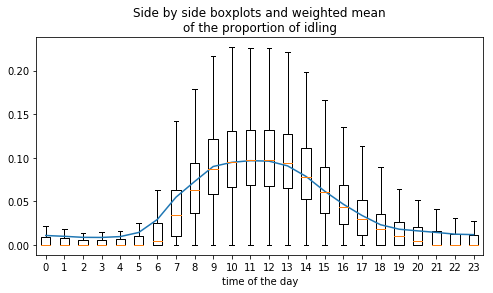

In [70]:
distribution = []
weight = []
for i in range(24):
    distribution.append(idle_hour[i].dropna())
    valid_prop = idle_hour[~np.isnan(idle_hour[i])]
    weight.append(np.dot(valid_prop[i], valid_prop.weight) / sum(valid_prop.weight))
    
fig = plt.figure(figsize=(8, 4))
plt.boxplot(distribution, showfliers=False)
plt.xticks(range(1,25), labels=list(range(0,24)))
plt.plot(range(1, 25), weight)
plt.title("Side by side boxplots and weighted mean\nof the proportion of idling")
plt.xlabel("time of the day");

Instead of two peaks at the rush hours, the peak is at the noon. Then, I suspected that the differences is caused by the large number of areas without much traffic congestions. Therefore, I narrow my sample to the BIA, which includes most of the commercial areas with higher traffic density. 

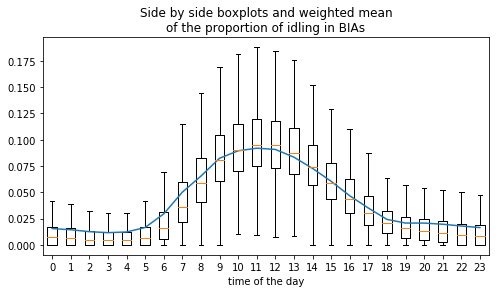

In [83]:
idle_hour_bia = idle_hour.merge(idling_bia[["bia", "Geohash"]], on="Geohash")
distribution = []
weight = []
for i in range(24):
    distribution.append(idle_hour_bia.loc[idle_hour_bia.bia][i].dropna())
    valid_prop = idle_hour_bia.loc[idle_hour_bia.bia][~np.isnan(idle_hour_bia.loc[idle_hour_bia.bia][i])]
    weight.append(np.dot(valid_prop[i], valid_prop.weight) / sum(valid_prop.weight))
    
fig = plt.figure(figsize=(8, 4))
plt.boxplot(distribution, showfliers=False)
plt.xticks(range(1,25), labels=list(range(0,24)))
plt.plot(range(1, 25), weight)
plt.title("Side by side boxplots and weighted mean\nof the proportion of idling in BIAs")
plt.xlabel("time of the day");

Although the peak in the BIA data is one hour prior to the peak in all data, the hourly distribution is still quite different from what we expected. 

Therefore, there is no evidence that the idling problem is related to the traffic jams. 

### 5.2. Is there a difference in hourly distribution of idling for different areas?

I'm interested in knowing when most idling happen for different places. With these crucial information, the city can apply efficient regulations for specific areas.

I started by finding the hour with the greatest idling volume in each geohash. By plotting them as a histogram, we can explore when most idling happens.

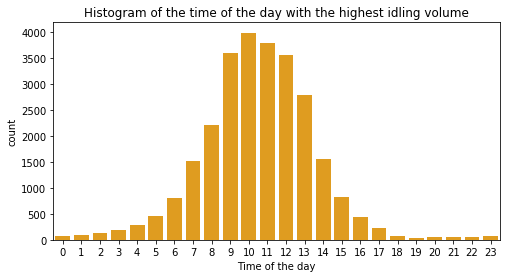

In [44]:
fig = plt.figure(figsize=(8, 4))
ax = sns.countplot(idle_hour.max_hour, color="orange")
ax.set_title("Histogram of the time of the day with the highest idling volume")
ax.set_xlabel("Time of the day");

Then, I looked at two categorizations: road type and whether BIA, as from the previous part. 

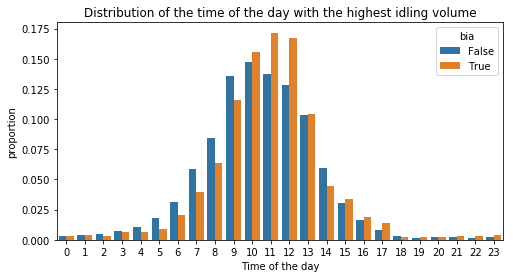

In [149]:
bia_count = Counter(idle_hour_bia.loc[idle_hour_bia.bia].max_hour)
not_bia_count = Counter(idle_hour_bia.loc[~idle_hour_bia.bia].max_hour)
def standarize(list_num):
    suming = sum(list_num)
    return [i/suming for i in list_num]
df = pd.DataFrame({"hour": list(bia_count.keys()), 
                   "prop":standarize(bia_count.values()), 
                   "counted": list(bia_count.values()), 
                   "bia": True})
df = df.append(pd.DataFrame({"hour": list(not_bia_count.keys()), 
                             "prop":standarize(not_bia_count.values()), 
                             "counted": list(not_bia_count.values()), 
                             "bia": False}))
fig = plt.figure(figsize=(8, 4))
ax = sns.barplot(x="hour", y="prop", hue="bia", data=df)
ax.set_title("Distribution of the time of the day with the highest idling volume")
ax.set_xlabel("Time of the day")
ax.set_ylabel("proportion");

In [172]:
rush_bia = df.loc[np.logical_and(df.bia, df.hour.isin((8,9,16,17)))].counted.sum()
lunch_bia = df.loc[np.logical_and(df.bia, df.hour.isin((11,13)))].counted.sum()
work_bia = df.loc[np.logical_and(df.bia, df.hour.isin((10,13,14)))].counted.sum()
rush_nbia = df.loc[np.logical_and(~df.bia, df.hour.isin((8,9,16,17)))].counted.sum()
lunch_nbia = df.loc[np.logical_and(~df.bia, df.hour.isin((11,13)))].counted.sum()
work_nbia = df.loc[np.logical_and(~df.bia, df.hour.isin((10,13,14)))].counted.sum()

table = sm.stats.Table([[rush_bia, rush_nbia], 
                        [lunch_bia, lunch_nbia], 
                        [work_bia, work_nbia]])
# print("p-value =", table.test_nominal_association().pvalue)
# print(table.fittedvalues)

The non-BIA areas has its peak one hour prior to BIAs. There is some differences between the two, while the difference is not very significant. Then, I categorize the day into "rush time", "lunch time", and "working time". I use the contingency table and chi-square test to determine whether the idling volume in different time intervals are dependent on whether the area is in some BIA. 

| - | BIA | non BIA | total |
| --- |--- | --- | --- |
|rush time (8-10, 16-18) |616 |5876 | 6492 |
|lunch time (11-13) |801 |5777 | 6578 |
|work time (10-11, 13-15)| 884|7443 |8327 |
total | 2301 | 19096 | 21397 |

\begin{center}
\textit{Number of geohashes with the greatest hourly distributed hour for each time interval and whether in BIA}
\end{center}

| - | BIA | non BIA | total |
| --- |--- | --- |---|
|rush time (8-10, 16-18) |698 |5794 | 6492 |
|lunch time (11-13) |707 |5871 | 6578 |
|work time (10-11, 13-15)| 895|7432 | 8327 | 
total | 2301 | 19096 | 21397 |

\begin{center}
\textit{Expected values of the contingency table}
\end{center}

The p-value is $4.0\times 10^{-6}$. Therefore, the idling volume in different time intervals are dependent on whether the area is in some BIA.

Then, I'm interested in whether the areas with idling problems have a distinct time distribution. For investigation, I plot the boxplot of the hourly proportion of idling volume from 8:00 to 20:00.

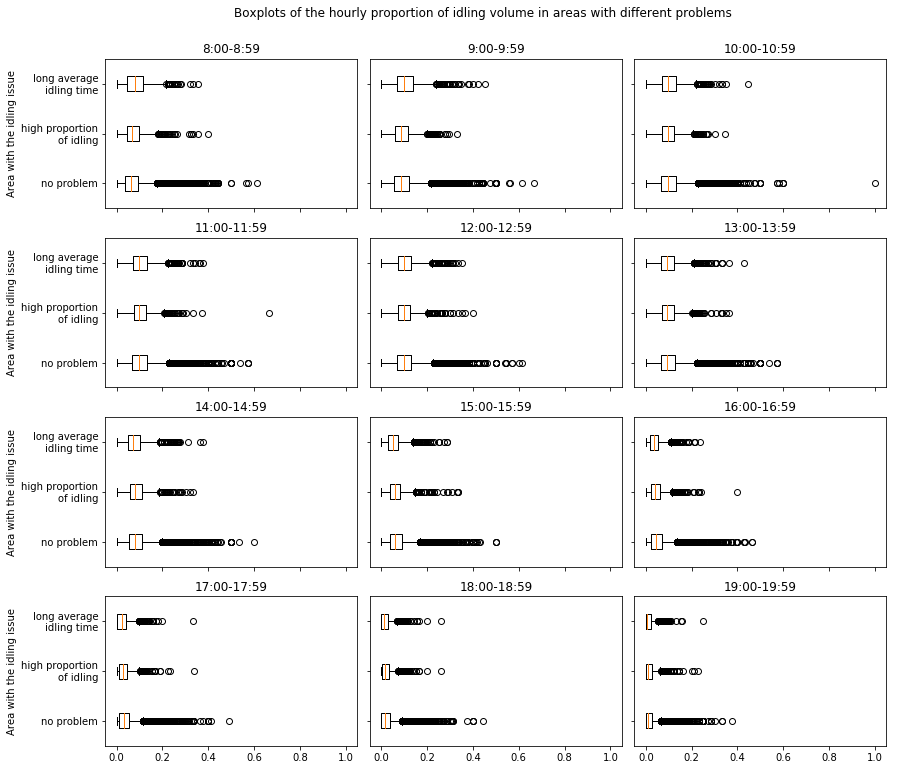

In [180]:
fig, axs = plt.subplots(4, 3, figsize=(14, 12), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.2, wspace = 0.05, top=0.92)
fig.suptitle("Boxplots of the hourly proportion of idling volume in areas with different problems")
for i in range(12):
    axs[i//3][i%3].boxplot([idle_hour.loc[np.logical_and(~idle_hour.proportion_p, ~idle_hour.time_p)][i+8].dropna(), 
                            idle_hour.loc[idle_hour.proportion_p][i+8].dropna(), 
                            idle_hour.loc[idle_hour.time_p][i+8].dropna()], showfliers=True, vert=False)
    axs[i//3][i%3].set_title(str(8+i)+":00-"+str(8+i)+":59")
    axs[i//3][i%3].set_yticklabels(['no problem', 'high proportion\nof idling', 'long average\nidling time'])
    axs[i//3][0].set_ylabel("Area with the idling issue")

From the boxplots, the distribution for the three types of areas are almost identical for each hour. The summary statistics are so very close. Therefore, the observation suggests that the hourly distribution of idling volume is independent of whether there is some idling problems associated with the area. 

## VI. What is the relationship between the types of vehicle and idling issues?

### 6.1. Does the type of vehicles associated with different kinds of idling problems?

Since idling can be caused by various reasons, we figured that types of vehicle might play a role as well. In our dataset, there are two measurements for types of vehicle, the first one is the percentage of this type of vehicle in a specific geohash (note that this is idling_type/idling_all), and the second one is the average idle time for each type of vehicle. The percentage gives us a sense of whether a type of veicle is a major issue in some areas, and the average time indicates the extent of idling issues. 

To get a general idea of what the data look like, a boxplot of all types of vehicles with their percentage are showed below. From the plot we can see that, type car has relatively low percentage of idling in each geohash, and the amount of data for type car only compose a very small portion of our data. So we only will further consider the other four vehicle types in our discussion. Moreover, for each type of vehicle, there are some points with extreme high percentage, so first we want to explore these data points a little bit more.

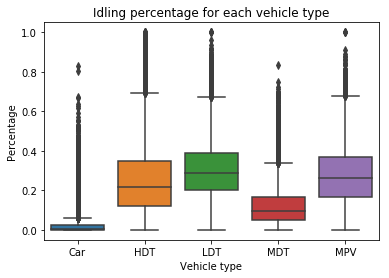

In [181]:
sns.boxplot(data = idling_area.iloc[:,[20, 23, 24, 25, 26]]) #, showfliers=False)
plt.ylabel("Percentage")
plt.xlabel("Vehicle type")
plt.xticks(np.arange(5),["Car", "HDT", "LDT", "MDT", "MPV"])
plt.title("Idling percentage for each vehicle type")
plt.show()

In [187]:
vehicle_type = ["HDT", "LDT", "MDT", "MPV"]
express = idling_roads[idling_roads["FCODE_DESC"]=="Expressway"]
major_arterial = idling_roads[idling_roads["FCODE_DESC"]=="Major Arterial"]
minor_arterial = idling_roads[idling_roads["FCODE_DESC"]=="Minor Arterial"]
local = idling_roads[idling_roads["FCODE_DESC"]=="Local"]

# function to calculate upper&lower whisker
def outlier(dat):
    upper_quartile = np.percentile(dat, 75)
    lower_quartile = np.percentile(dat, 25)

    iqr = upper_quartile - lower_quartile
    upper_whisker = dat[dat <= upper_quartile + 1.5 * iqr].max()
    lower_whisker = dat[dat >= lower_quartile - 1.5 * iqr].min()
    return (lower_whisker, upper_whisker, lower_quartile, upper_quartile)

# find the outliers that we want to plot
# outliers for each types of vehicles on some road_type
def get_outliers(ret, road_type, attributes):
    for i in range(4):
        att = attributes[i]
        out = outlier(road_type[att])
        ret.append(road_type.loc[(road_type[att] < out[0]) | (road_type[att] > out[1])])
    return ret

# get outliers for idling percentage
perc = ["PercentHDT", "PercentLDT", "PercentMDT", "PercentMPV"]
out_per_express = get_outliers([], express, perc)
out_per_major = get_outliers([], major_arterial, perc)
out_per_minor = get_outliers([], minor_arterial, perc)
out_per_local = get_outliers([], local, perc)

And before we examine the pattern of those outliers, we want to take a closer look of the usage of each type of vehicles. 
- Heavy duty truck (HDT): transportation of large cargo
- Light duty truck (LDT): light transportation such as small furniture, small equipments
- Medium duty truck (MDT): carry moderate amount of cargo, some examples such as: delivery truck, garbage trucks
- Multi-purpose passenger vehicle (MPV): vehicle that can be used in multiple ways but with up to 10 people

To have a better idea of those outliers, we categorized them based on road types they idle on and plot the outliers in our maps. We can see a pattern that west part of Toronto is mostly coloured in green, which represents HDT. And if we go to the east part of our map, more and more purple and pink dots are present, which indicate MDT and MPV respectively. On second thoughts, Etobicoke, the west part of Toronto, has lots of truck services companies, warehouses, truck driving schools, which might explains the high percentage of HDT. And for the east part of Toronto, most of the areas tend to have neighboorhood setting, and that might be an explanation of why daily life related vehicles have higher percentage there.

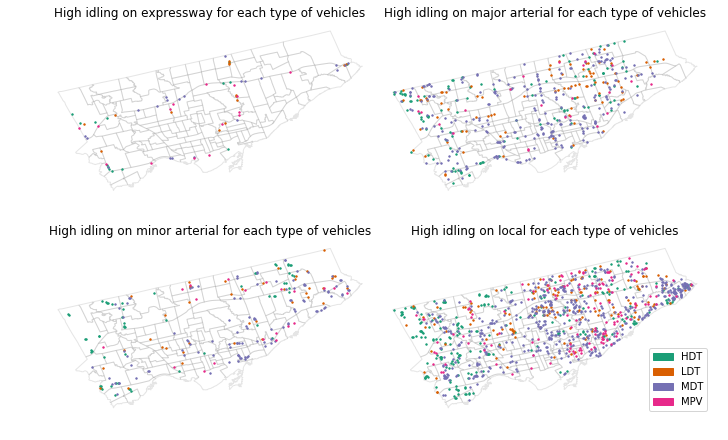

In [241]:
out_per = [out_per_express, out_per_major, 
           out_per_minor, out_per_local]

fig, axs = plt.subplots(2, 2, figsize = (12, 8))
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(4):
    handles = []
    axs[i//2][i%2].set_axis_off()
    neighboorhoods.plot(alpha = 0.2, color = "white", edgecolor = "grey", 
                        linewidth = 1, ax = axs[i//2][i%2])
    for j in range(4):
        out_per[i][j]["geometry"].centroid.plot(color = color[j], 
                                                ax = axs[i//2][i%2], 
                                                markersize = 2)
        handles.append(Patch(color=color[j], label=vehicle_type[j]))
    axs[i//2][i%2].set_title("High idling on " + chosen_type[i].lower() + " for each type of vehicles")
plt.legend(handles=handles, loc=4)
plt.show()

### 6.2. Does the effect of road types on idling problems differ with vehicle types?

After exploring the outliers of percentage, we plot the data in boxplot again, but in different road types to see if the distribution of percentage of vehicle types is independent of road types. And if that is the case, we do not need to consider road types factors later on. 

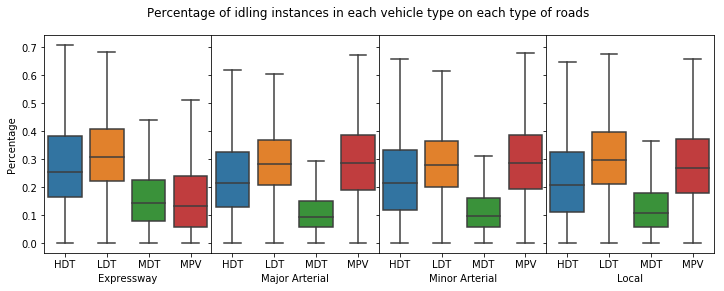

In [242]:
data_idling = [express, major_arterial, minor_arterial, local]
fig, axs = plt.subplots(1, 4, figsize=(12, 4), sharey=True)
plt.subplots_adjust(wspace=0)
for i in range(4):
    sns.boxplot(data = data_idling[i].iloc[:, 23:27], 
                ax=axs[i], showfliers=False)
    axs[i].set_xlabel(chosen_type[i])
    axs[i].set_xticklabels(vehicle_type)
axs[0].set_ylabel("Percentage")
plt.suptitle("Percentage of idling instances in each vehicle type on each type of roads")
plt.show()

From the graph, we can tell that the distribution between major arterial, minor arterial and local areas are similar, while expressway seems a bit different. So we decided to count larger than 10% as a idling problem, and count the frequency of idling problem for each type. After that, we can do chi-square test.

In [221]:
idling_cont = idling_roads.iloc[:, [2,3,4,5,23,24,25,26,-3]]
cont_types = idling_cont.iloc[:, -1]

idling_per = idling_cont.iloc[:, 4:8]
idling_per = idling_per[idling_per >= 0.10]
idling_percont = idling_per.join(cont_types).groupby("FCODE_DESC").count()
# idling_percont

|- |HDT | LDT | MDT | MPV | 
|---|---|---|---|---|
|expressway|892|961|662|611|
|local|10666|13071|7247|12591|
|major arterial | 4363|5109|2463|4821|
|minor arterial|2214|2597|1340|2512|

\begin{center}
\textit{Number of areas with idling problems for each vehicle type on each road type}
\end{center}

In [222]:
table = sm.stats.Table(idling_percont)
# table.fittedvalues

|- |HDT | LDT | MDT | MPV | 
|---|---|---|---|---|
|expressway|786|942|508|890|
|local|10957|13134|7076|12407|
|major arterial | 4213|5051|2721|4770|
|minor arterial|2178|2611|14067|24667|

\begin{center}
\textit{Expected values of the contingency table}
\end{center}

In [227]:
# table.test_nominal_association().pvalue

The p-value for this test is 0.0, so we reject the null hypothesis at 95% interval. And the result makes sense becaues each road type has different settings, and is designed for different usage. Therefore, there is some relationship between road types and vehicle types.

After examing the percentage data, we want to know if the average idle time distribution for each vehicle type is similar among different types of roads. Therefore, we plot the data in a boxplot again and try the chi-square test. But this time, indication of idling problem is time greater than or equal to 10 minutes.

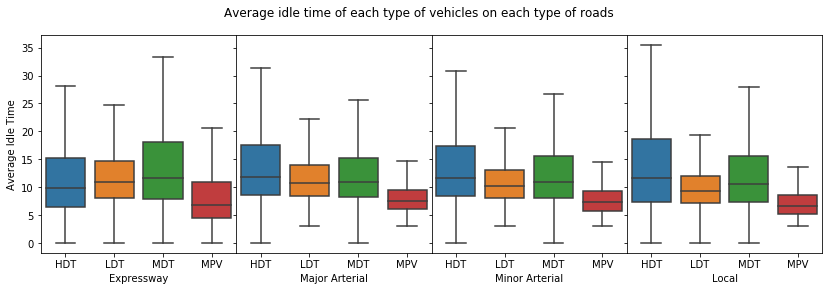

In [223]:
fig, axs = plt.subplots(1, 4, figsize=(14, 4), sharey=True)
plt.subplots_adjust(wspace=0)
for i in range(4):
    sns.boxplot(data = data_idling[i].iloc[:, 2:6], 
                ax=axs[i], showfliers=False)
    axs[i].set_xlabel(chosen_type[i])
    axs[i].set_xticklabels(vehicle_type)
axs[0].set_ylabel("Average Idle Time")
plt.suptitle("Average idle time of each type of vehicles on each type of roads")
plt.show()

In [224]:
idling_time = idling_cont.iloc[:, :4]
idling_time = idling_time[idling_time >= 10]
idling_timecont = idling_time.join(cont_types).groupby("FCODE_DESC").count()
# idling_timecont

|- |HDT | LDT | MDT | MPV | 
|---|---|---|---|---|
|expressway|486|564|618|292|
|local|8046|5690|7320|2107|
|major arterial | 3298|3009|3026|1113|
|minor arterial|1713|1423|1565|566|

\begin{center}
\textit{Number of idling problems for each vehicle type on each road type}
\end{center}

In [228]:
table = sm.stats.Table(idling_timecont)
# table.fittedvalues

|- |HDT | LDT | MDT | MPV | 
|---|---|---|---|---|
|expressway|650|513|601|196|
|local|7682|6061|7107|2313|
|major arterial | 3464|2734|3205|1043|
|minor arterial|1747|1378|1616|526|

In [226]:
# table.test_nominal_association().pvalue

P-value for this question is also 0, which indicates that we reject our null hypothesis at 95% confidence interval. From the expected values of the contingency table, we can see that all types of cars have lower than expected idling on expressway, and this makes sense because it is dangourous for cars to idle on expressway.

### 6.3. Does the effect of BIA on idling problems differ with vehicle types?

After considering road types, we want to see if business area category also plays a role when it comes to vehicle types. We first consider the percentage and do the chi-square test.

In [206]:
idling_b = idling_bia[idling_bia["bia"] == True] #.iloc[:, [2,3,4,5,23,24,25,26]]
idling_nb = idling_bia[idling_bia["bia"] == False] #.iloc[:, [2,3,4,5,23,24,25,26]]
bnb_idling = [idling_b, idling_nb]

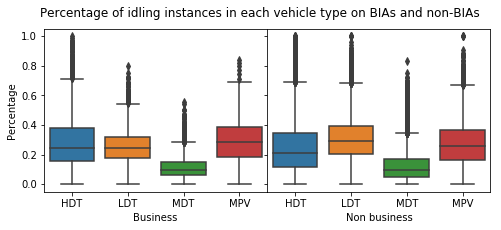

In [243]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
plt.subplots_adjust(wspace=0)
for i in range(2):
    sns.boxplot(data = bnb_idling[i].iloc[:, 23:27], 
                ax=axs[i]) #, showfliers=False)
    axs[i].set_xlabel(["Business", "Non business"][i])
    axs[i].set_xticklabels(vehicle_type)
axs[0].set_ylabel("Percentage")
plt.suptitle("Percentage of idling instances in each vehicle type on BIAs and non-BIAs")
plt.show()

In [230]:
areas_cont = idling_bia.iloc[:, [2,3,4,5,23,24,25,26,-1]]
cont_types = areas_cont.iloc[:, -1]

areas_per = areas_cont.iloc[:, 4:8]
areas_per = areas_per[areas_per >= 0.1]
areas_percont = areas_per.join(cont_types).groupby("bia").count()
# areas_percont

|- |HDT | LDT | MDT | MPV | 
|---|---|---|---|---|
|not-BIA|19027|22733|11768|21190|
|BIA|2608|2720|1397|2570|


\begin{center}
\textit{Number of idling problems for each vehicle type on different areas}
\end{center}

In [232]:
table = sm.stats.Table(areas_percont)
# table.fittedvalues

|- |HDT | LDT | MDT | MPV | 
|---|---|---|---|---|
|not-BIA|19241|22637|11708|21131|
|BIA|2394|2816|1457|2629|


\begin{center}
\textit{Expected values of the contingency table}
\end{center}

In [231]:
# table.test_nominal_association().pvalue

$1.77 \times 10^{-6}$ as a p-value makes us reject our null hypothesis that percentage of each vehicle type on business and non-business area are independent. Notice how HDT idle more than we expected in BIA, and this can be explained by some parts of BIA contain lots of warehouses.

Same test is carried out with respect to average idle time as well.

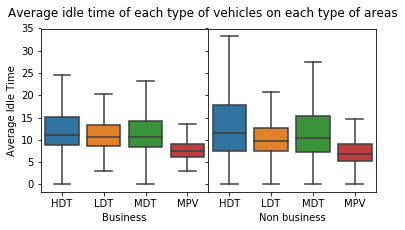

In [246]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
plt.subplots_adjust(wspace=0)
for i in range(2):
    sns.boxplot(data = bnb_idling[i].iloc[:, 2:6], 
                ax=axs[i], showfliers=False)
    axs[i].set_xlabel(["Business", "Non business"][i])
    axs[i].set_xticklabels(vehicle_type)
axs[0].set_ylabel("Average Idle Time")
plt.suptitle("Average idle time of each type of vehicles on each type of areas");

In [233]:
areas_time = areas_cont.iloc[:, :4]
areas_time = areas_time[areas_time >= 10]
areas_timecont = areas_time.join(cont_types).groupby("bia").count()
# areas_timecont

|- |HDT | LDT | MDT | MPV | 
|---|---|---|---|---|
|not-BIA|14102|11199|12657|4407|
|BIA|1782|1634|1651|551|


\begin{center}
\textit{Number of idling problems for each vehicle type on different areas}
\end{center}

In [234]:
table = sm.stats.Table(areas_timecont)
# table.fittedvalues

|- |HDT | LDT | MDT | MPV | 
|---|---|---|---|---|
|not-BIA|14024|11330|12633|4378|
|BIA|1860|1503|1675|580|


\begin{center}
\textit{Expected values of the contingency table}
\end{center}

In [215]:
p_value = table.test_nominal_association().pvalue

This time our p-value is 0.0003, and we reject our null hypothesis at 95% confidence level.

## VII. Conclusion

After the observation of several factors, we found some points that might be helpful when studying how to reduce idling time. First of all, idling happens mostly in local, small areas. This can be explained by the fact that a lot of local services are done with the help of vehicles and people usually do not turn off the engine while making a short stop. Secondly, although business areas have overall small proportion of idling, idling problems are more likely to happen in business areas. And whether or not a place is categorized as business area also affects the percentage of vehicle types that idle there. What is more, different areas and road types also play important roles in idling problems. Some specific type of commercial vehicles tend to idle at the areas that they are used (i.e., loading cargo, collecting garbage, distributing parcels) and different settings (i.e., capacity) of road types can also have different idling issues. Last but not the least, although we thought traffic might be one of the major factors that affect idling time, our observation result does not align with our hypothesis but vehicles do idle more at some particular time of a day - late morning and noon. 

With these conclusion in hands, we think there are a couple of things that we can do to reduce the time of idling in Toronto, and they are all related to how to reinforce the regulations. Because in Toronto, idling more than one minute can be charged \$125 in fines. Now that we know some patterns about idling, we can assign inspection team to finish the task in a more efficient way. To start, more people can be assigned at business areas at late morning and noon to check if vehicles obey the rule. Meanwhile, truck services and driving schools definitely need more attention because truck has more pollution to the environment when it comes to idling. Moreover, as some of vehicles that idling belongs to city services, such as garbage trucks, government can take the lead to reduce idling time and reward companies that are willing to put effort in it, we believe more and more individuals will be aware of this issue.

## VIII. Limitations

There are several limitations about this analysis. This dataset only contains commercial vehicles that use GEOTAB and that cannot be counted as a good representation of all commercial vehicles in Toronto. And the amount of data that are provided for different types of vehicles are not balance. Car has relatively a very small portion of data in the dataset, so we cannot actually study the trend for type car. On the other hand, idling can be affected by lots of factors, and different factors play different roles in idling issues. Thus, the number of factors we considered in this analysis is far from enough for us to generate a regression model to predict the idling time of certain type of vehicle at certain area. And details classification of each category, for example, subcategories for non-business areas, might also be helpful in future study.

## References

<a href="#p_ourdata" id="r_ourdata">1</a>. Geotab. _What is Geotab's Telematics Data?_.  
https://data.geotab.com/our-data

<a href="#p_tcl" id="r_tcl">2</a>. City of Toronto. _Toronto Centreline (TCL)_.  
https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/#e4ec3384-056f-aa59-70f7-9ad7706f31a3

<a href="#p_bia" id="r_bia">3</a>. City of Toronto. _Business Improvement Areas_.  
https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/#2492fc58-6ae0-fa22-aecf-6e7b5392494b

<a href="#p_neighbor" id="r_neighbor">4</a>. City of Toronto. _Neighbourhoods_.  
https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/locations-and-mapping/#a45bd45a-ede8-730e-1abc-93105b2c439f

<a href="#p_congestion" id="r_congestion">5</a>. McMaster Institute for Transportation and Logistics. _Congestion Trends in the
City of Toronto (2011-2014)_.  
https://www.toronto.ca/wp-content/uploads/2017/11/91f0-city_congestion_trends_09-15-2015.pdf
